In [16]:
from math import sqrt
import sys
if "clg" in sys.modules:
    del sys.modules["clg"]
from clg import noise, Norm

In [17]:
import numpy as np

A = "A" @ (sqrt(2) * noise)
K = "K" @ (3 + noise)
B = "B" @ (1 + A + noise)
C = "C" @ ((-3 + 2 * B) + 0.5 * noise)
D = "D" @ (B + 2 * K)
A & K

true_µ = A.get_μ().round(2)
true_cov = A.get_Σ().round(2)
samples = A.sample(1000)

A.fit_data(samples)

print("LEARNT PARAMETERS:")
learnt_µ = A.get_μ().round(2)
learnt_cov = A.get_Σ().round(2)

print("cov error", np.linalg.norm(true_cov - learnt_cov))
print("µ error", np.linalg.norm(true_μ - learnt_μ))

print("NAIVE  PARAMETERS:")
naive_µ = (samples).mean().round(2)
naive_cov = (samples).cov().round(2)

print("cov error", np.linalg.norm(true_cov - naive_cov))
print("µ error", np.linalg.norm(true_μ - naive_μ))


LEARNT PARAMETERS:
cov error 0.0
µ error 0.0
NAIVE  PARAMETERS:
cov error 0.3246536616149587
µ error 0.038729833462074065


### Converting any multivariate gaussian to a CLG

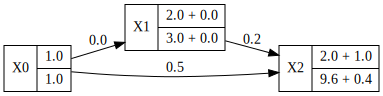

X0    1.0
X1    2.0
X2    3.0
dtype: float64
     X0   X1    X2
X0  1.0  0.0   0.5
X1  0.0  3.0   0.7
X2  0.5  0.7  10.0


In [24]:
def to_clg(mean : np.ndarray, cov : np.ndarray) -> Norm:   

    scope = [f"X{i}" for i in range(len(mean))]
    # create a dense CLG
    # cov(0, 1) = alpha * cov(0,0) => alpha = cov(0, 1) / cov(0, 0)

    first : Norm = scope[0] @ (noise * sqrt(cov[0, 0]) + mean[0])
    parents = [first]

    for i in range(1, len(mean)):
        var = 0
        mean_total = 0

        n = noise * 0

        for p in range(i):
            # for each parent make to covariance right
            alpha = cov[i, p] / cov[p, p]
            n += alpha * parents[p]

            var += (alpha * parents[p].current_sd)**2 
            mean_total += alpha * parents[p].current_mean


        remaining_var = cov[i, i] - var
        remaining_mean = mean[i] - mean_total
        # add independent noise at the end to get the right variance
        n += noise * sqrt(remaining_var)
        # add the mean to get the right mean
        n += remaining_mean
        
        # baptize it :)
        n @= scope[i]
        n : Norm = n
        # n.__recompute_params__()
        parents += [n]
    

    first.__recompute_params__()
    return first

mean = np.array([1, 2, 3])
cov = np.array([[1, 0.0, 0.5], [0.0, 3, 0.7], [0.5, 0.7, 10]])


norm = to_clg(mean, cov)
display(norm.get_graph(detailed=True))
print(norm.get_µ())
print(norm.get_Σ())